In [ ]:
!pip install qiskit

In [ ]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.providers.aer import noise
IBMQ.save_account('f5ac861d9299009bb9420b5feff6abc90cbdfd8f8e38789005db20855c142db3a864799f73d25bb1b5ec6acdaebce19d24fafcbaa9e7d929fc763633ad279747')
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import json
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

configrc.store_credentials:WARNING:2020-08-07 08:50:13,911: Credentials already present. Set overwrite=True to overwrite.


In [ ]:
def save_result(file_name, result):
  dir = '/content/drive/My Drive/Projects/Qiskit Global Summer School/'
  with open(dir + file_name, 'w') as f:
      f.write(json.dumps(result))

def load_result(file_name):
  # Now read the file back into a Python list object
  dir = '/content/drive/My Drive/Projects/Qiskit Global Summer School/'
  with open(dir + file_name, 'r') as f:
      a = json.loads(f.read())
  
  return a

# Qiskit Summer School Final Project: VQE

#### For this optional final challenge, you will be designing your own implementation of a variational quantum eigensolver (VQE) algorithm that simulates the ground state energy of the Lithium Hydride (LiH) molecule. Through out this challenge, you will be able to make choices on how you want to compose your simulation and what is the final deliverable that you want to showcase to your classmates and friends.

# Defining your molecule:
In this challenge we will focus on LiH using the sto3g basis with the PySCF driver, which can be described in Qiskit as follows, where 'inter_dist' is the interatomic distance.

In [ ]:
inter_dist = 1.6

driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')

We also setup the molecular orbitals to be considered and can reduce the problem size when we map to the qubit Hamiltonian so the amount of time required for the simulations are reasonable for a laptop computer.

In [ ]:
# please be aware that the idx here with respective to original idx
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order

#### Once you have computed the qubit operations for LiH, you can use the following function to classical solve for the exact solution. This is used just to compare how well your VQE approximation is performing.

In [ ]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

Here we ask you to use the `statevector_simulator` as the simulation backend for your VQE algorithm.

In [ ]:
backend = BasicAer.get_backend('statevector_simulator')

### Now you can start choosing the components that make up your VQE algorithm!

#### 1. Optimizers
The most commonly used optimizers are `COBYLA`, `L_BFGS_B`, `SLSQP` and `SPSA`. 

#### 2. Qubit mapping
There are several different mappings for your qubit Hamiltonian, `parity`, `bravyi_kitaev`, `jordan_wigner`, which in some cases can allow you to further reduce the problem size.

#### 3. Initial state
There are different initial state that you can choose to start your simulation. Typically people choose from the zero state 
`init_state = Zero(qubitOp.num_qubits)` 
and the UCCSD initial state
`HartreeFock(qubitOp.num_qubits, num_spin_orbitals, num_particles, map_type, qubit_reduction)`

#### 4. Parameterized circuit
There are different choices you can make on the form of variational forms of your parameterized circuit.

`UCCSD_var_form = UCCSD(num_qubits, depth=depth, num_orbitals=num_spin_orbitals, num_particles=num_particles)`
    
`RY_var_form = RY(num_qubits, depth=depth)`
    
`RYRZ_var_form = RYRZ(num_qubits, depth=depth)`
    
`swaprz_var_form = SwapRZ(num_qubits, depth=depth)`

#### 5. Simulation backend
There are different simulation backends that you can use to perform your simulation

`backend = BasicAer.get_backend('statevector_simulator')`

`backend=Aer.get_backend('qasm_simulator')`

### Compare the convergence of different choices for building your VQE algorithm

Among the above choices, which combination do you think would out perform others and give you the lowest estimation of LiH ground state energy with the quickest convergence? Compare the results of different combinations against each other and against the classically computed exact solution at a fixed interatomic distance, for example `inter_dist=1.6`. 

To access the intermediate data during the optimization, you would need to utilize the `callback` option in the VQE function:

`def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)`
            
`algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)`

`algo_result = algo.run(quantum_instance)`

An example of comparing the performance of different optimizers while using the RY variational ansatz could like the following:
![RY_error.png](attachment:RY_error.png)
![RY_convergence.png](attachment:RY_convergence.png)

### Compute the ground state energy of LiH at various different interatomic distances
By changing the parameter `inter_dist`, you can use your VQE algorithm to calculate the ground state energy of LiH at various interatomic distances, and potentially produce a plot as you are seeing here. Note that the VQE results are very close to the exact results, and so the exact energy curve is hidden by the VQE curve.
<img src="attachment:VQE_dist.png" width="600">

### How does your VQE algorithm perform in the presence of noise?
Trying importing the noise model and qubit coupling map of a real IBM quantum device into your simulation. You can use the imported noise model in your simulation by passing it into your quantum instance. You can also try enabling error mitigation in order to lower the effect of noise on your simulation results.

In [ ]:
#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


An example of comparing the energy convergence of using SPSA and COBYLA with the ibmq_essex noise model could look like the following
![noise.png](attachment:noise.png)

### Now given the choices you have made above, try writing your own VQE algorithm in Qiskit. You can find an example of using Qiskit to simuate molecules with VQE [here](https://qiskit.org/textbook/ch-applications/vqe-molecules.html).

In [ ]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    #print('Reference value: {}'.format(ref))
    return ref

# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    #print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    #print("# of electrons: {}".format(num_particles))
    #print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, energy_shift, nuclear_repulsion_energy


def test_run(mapping_type, inter_distance, backend_type, init_type, use_noise, optimizer_type, param_type):
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction = compute_LiH_qubitOp(map_type=mapping_type, inter_dist=inter_distance)
    print("Orbitals: ", num_spin_orbitals)
    print("Particles: ", num_particles)
    # Classically solve for the exact solution and use that as your reference value
    ref = exact_solver(qubitOp)

    # Specify your initial state
    if init_type == 'HF':
      init_state = HartreeFock(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping=mapping_type, two_qubit_reduction=True)
    elif init_type == 'Zero':
      init_state = Zero(qubitOp.num_qubits)
    elif init_type == 'None':
      init_state = None

    # Select a state preparation ansatz
    # Equivalently, choose a parameterization for our trial wave function.
    if param_type == 'UCCSD':
      var_form = UCCSD(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping=mapping_type,
                            initial_state=init_state, two_qubit_reduction=True)
    elif param_type == 'RY':
      var_form = RY(num_qubits=qubitOp.num_qubits, entanglement="linear", initial_state=init_state, depth=1)
    elif param_type == 'RYRZ':
      var_form = RYRZ(num_qubits=qubitOp.num_qubits, entanglement="linear", initial_state=init_state)
    elif param_type == 'SwapRZ':
      var_form = SwapRZ(num_qubits=qubitOp.num_qubits, entanglement="linear", initial_state=init_state)
    elif param_type == 'ESU2':
      var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear", initial_state=init_state)


    # Choose where to run/simulate our circuit
    if backend_type == 'qasm': 
      backend = Aer.get_backend('qasm_simulator')
    elif backend_type == 'statevector':
      backend = BasicAer.get_backend('statevector_simulator')

    # Choose whether to use noise or not
    if use_noise == False:
      quantum_instance = backend
    elif use_noise == True:
      backend = Aer.get_backend('qasm_simulator')
      #Define our noise model based on the ibmq_essex chip
      chip_name = 'ibmq_essex'
      device = provider.get_backend(chip_name)
      coupling_map = device.configuration().coupling_map
      noise_model = noise.device.basic_device_noise_model(device.properties())
      basis_gates = noise_model.basis_gates
      quantum_instance = QuantumInstance(backend=backend, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   basis_gates=basis_gates,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)
      # measurement_error_mitigation_cls=CompleteMeasFitter
      # cals_matrix_refresh_period=30

    # Choose the classical optimizer
    if optimizer_type == 'COBYLA':
      optimizer = COBYLA(maxiter=100)
    elif optimizer_type == 'L_BFGS_B':
      optimizer = L_BFGS_B(maxfun=100, maxiter=1500)
    elif optimizer_type == 'SLSQP':
      optimizer = SLSQP(maxiter=100)
    elif optimizer_type == 'SPSA':
      optimizer = SPSA(max_trials=100)

    # Run your VQE instance
    vqe = VQE(qubitOp, var_form, optimizer)
    # Now compare the results of different compositions of your VQE algorithm!
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue'])
    return abs(vqe_result - ref)
    #print("VQE Result:", vqe_result)


mapping_list = ['parity', 'bravyi_kitaev', 'jordan_wigner']
init_state_list = ['HF', 'Zero']
backend_list = ['statevector', 'qasm']
optimizer_list = ['COBYLA', 'L_BFGS_B', 'SLSQP', 'SPSA']
param_list = ['UCCSD', 'RY', 'RYRZ', 'SwapRZ']


In [ ]:
def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            #params.append(parameters)
            deviation.append(std)

In [ ]:
a = np.array([[0, 0, 0], [0,0,0]])
b = [1, 2, 3]

a[0,:] = np.array(b)
a

array([[1, 2, 3],
       [0, 0, 0]])

In [ ]:
def convergence_test(mapping_type, optimizer_type, inter_distance):
  qubitOp, num_spin_orbitals, num_particles, qubit_reduction = compute_LiH_qubitOp(map_type=mapping_type, inter_dist=inter_distance)
  print("Orbitals: ", num_spin_orbitals)
  print("Particles: ", num_particles)
  # Classically solve for the exact solution and use that as your reference value
  ref = exact_solver(qubitOp)

  # Specify your initial state
  init_state = HartreeFock(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping=mapping_type, two_qubit_reduction=True)


  # Select a state preparation ansatz
  # Equivalently, choose a parameterization for our trial wave function.
  var_form = RY(num_qubits=qubitOp.num_qubits, entanglement="linear", initial_state=init_state)

  backend = Aer.get_backend('qasm_simulator')
  #Define our noise model based on the ibmq_essex chip
  chip_name = 'ibmq_essex'
  device = provider.get_backend(chip_name)
  coupling_map = device.configuration().coupling_map
  noise_model = noise.device.basic_device_noise_model(device.properties())
  basis_gates = noise_model.basis_gates
  quantum_instance = QuantumInstance(backend=backend, 
                                shots=1000, 
                                noise_model=noise_model, 
                                coupling_map=coupling_map,
                                basis_gates=basis_gates,
                                measurement_error_mitigation_cls=CompleteMeasFitter,
                                cals_matrix_refresh_period=30)

  # Choose the classical optimizer
  if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=100)
  elif optimizer_type == 'SPSA':
    optimizer = SPSA(max_trials=100)

  # Run your VQE instance
  vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
  # Now compare the results of different compositions of your VQE algorithm!
  ret = vqe.run(quantum_instance)
  vqe_result = np.real(ret['eigenvalue'])
  err = abs(vqe_result - ref)
  #print("Abs error: ", err)



mapping_type = 'parity'
optimizer_type = 'COBYLA'
#inter_distance = 1.6

dist_list = [0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

values_all = np.zeros((len(dist_list), 100))
counts_all = np.zeros((len(dist_list), 100))
deviation_all = np.zeros((len(dist_list), 100))

for i in range (len(dist_list)):
  counts = []
  values = []
  deviation = []
  convergence_test(mapping_type, optimizer_type, dist_list[i])
  counts_all[i,:] = np.array(counts)
  values_all[i,:] = np.array(values)
  deviation_all[i,:] = np.array(deviation)

Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` cl

Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


In [ ]:
cobyla_counts = counts
cobyla_values = values
cobyla_deviation = deviation
cobyla_params = params

In [ ]:
spsa_counts = counts
spsa_values = values
spsa_deviation = deviation
spsa_params = params

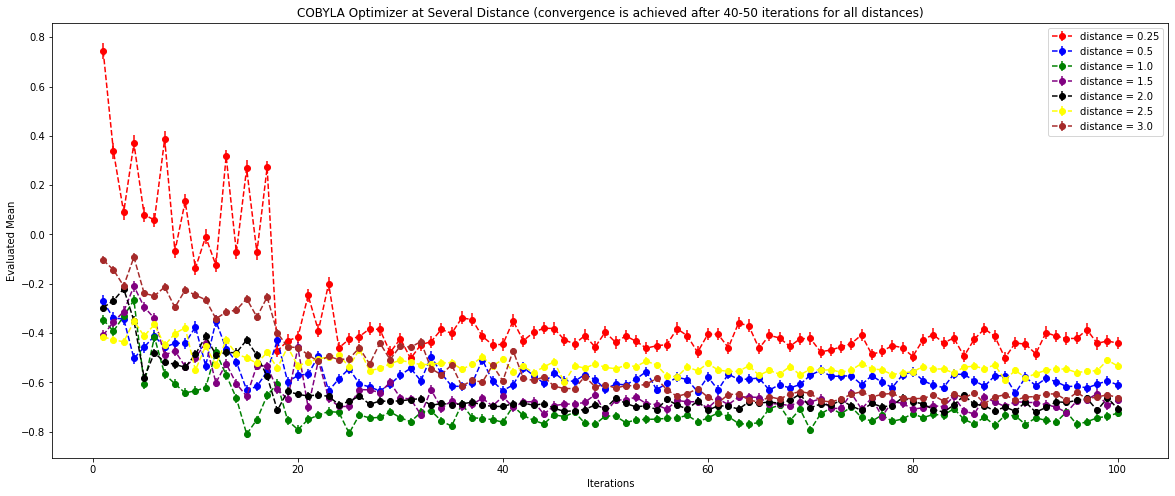

In [ ]:
color_list = ['red', 'blue', 'green', 'purple', 'black', 'yellow', 'brown']

for i in range (len(dist_list)):
  plt.errorbar(counts_all[i,:], values_all[i,:], deviation_all[i,:], linestyle='--', marker='o', color=color_list[i], label='distance = ' + str(dist_list[i]))

plt.title('COBYLA Optimizer at Several Distance (convergence is achieved after 40-50 iterations for all distances)')
plt.xlabel('Iterations')
plt.ylabel('Evaluated Mean')
plt.legend()

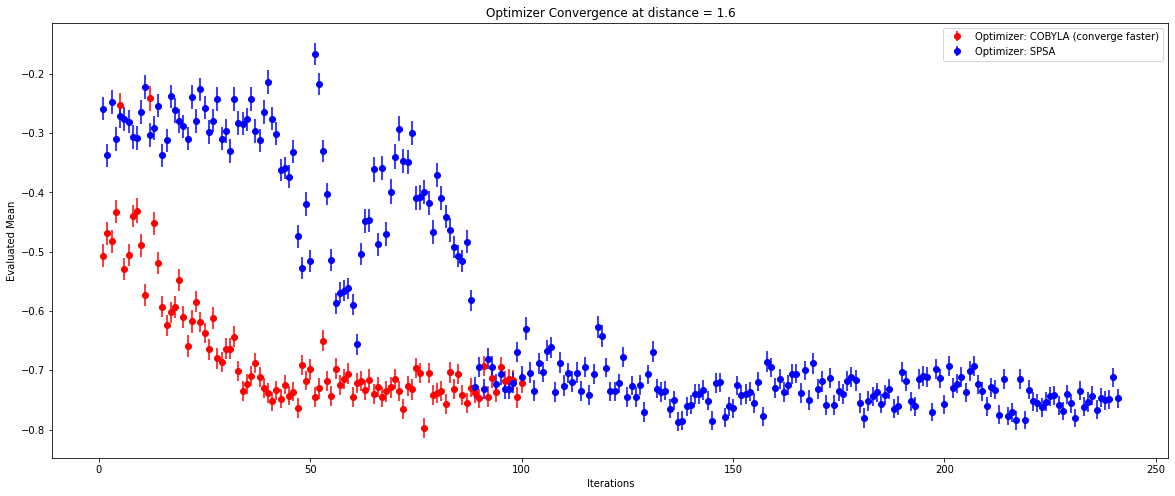

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.errorbar(cobyla_counts, cobyla_values, cobyla_deviation, linestyle='None', marker='o', color='red', label='Optimizer: COBYLA (converge faster)')
plt.errorbar(spsa_counts, spsa_values, spsa_deviation, linestyle='None', marker='o', color='blue', label='Optimizer: SPSA')
plt.title('Optimizer Convergence at distance = 1.6')
plt.xlabel('Iterations')
plt.ylabel('Evaluated Mean')
plt.legend()

In [ ]:
def depth_test(mapping_type, inter_distance, num_depth):
  qubitOp, num_spin_orbitals, num_particles, qubit_reduction, eshift, erepulsion = compute_LiH_qubitOp(map_type=mapping_type, inter_dist=inter_distance)
  print("Orbitals: ", num_spin_orbitals)
  print("Particles: ", num_particles)
  # Classically solve for the exact solution and use that as your reference value
  #ref = exact_solver(qubitOp)

  # Specify your initial state
  init_state = HartreeFock(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping=mapping_type, two_qubit_reduction=True)


  # Select a state preparation ansatz
  # Equivalently, choose a parameterization for our trial wave function.
  var_form = RY(num_qubits=qubitOp.num_qubits, entanglement="linear", initial_state=init_state, depth=num_depth)

  backend = Aer.get_backend('qasm_simulator')
  #Define our noise model based on the ibmq_essex chip
  chip_name = 'ibmq_essex'
  device = provider.get_backend(chip_name)
  coupling_map = device.configuration().coupling_map
  noise_model = noise.device.basic_device_noise_model(device.properties())
  basis_gates = noise_model.basis_gates
  quantum_instance = QuantumInstance(backend=backend, 
                                shots=1000, 
                                noise_model=noise_model, 
                                coupling_map=coupling_map,
                                basis_gates=basis_gates,
                                measurement_error_mitigation_cls=CompleteMeasFitter,
                                cals_matrix_refresh_period=30)

  # Choose the classical optimizer
  optimizer = COBYLA(maxiter=50)

  # Run your VQE instance
  vqe = VQE(qubitOp, var_form, optimizer)
  # Now compare the results of different compositions of your VQE algorithm!
  ret = vqe.run(quantum_instance)
  vqe_result = np.real(ret['eigenvalue'])
  #err = abs(vqe_result - ref)
  return (vqe_result+eshift+erepulsion)
  #print("Abs error: ", err)




In [ ]:
mapping_type = 'parity'

depth_list = [1, 3, 5, 7]
dist_list = np.linspace(0.5, 3.0, 21)

ref_all = np.zeros((len(depth_list), len(dist_list)))
vqe_all = np.zeros((len(depth_list), len(dist_list)))

In [ ]:
num_depth = 7
row = 3

for i in range (len(dist_list)):
  result = depth_test(mapping_type, dist_list[i], num_depth)
  #ref_all[row, i] = ref
  vqe_all[row, i] = result
  np.savetxt('/content/drive/My Drive/Projects/Qiskit Global Summer School/vqe_result.txt', vqe_all, delimiter=',')
  #np.savetxt('/content/drive/My Drive/Projects/Qiskit Global Summer School/ref_result.txt', ref_all, delimiter=',')
  print("Dist: " + str(dist_list[i]))

Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 0.5
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 0.625
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 0.75
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 0.875
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 1.0
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 1.125
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 1.25
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 1.375
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 1.5
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 1.625
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 1.75
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 1.875
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 2.0
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 2.125
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 2.25
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 2.375
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 2.5
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 2.625
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 2.75
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 2.875
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Dist: 3.0


In [ ]:
row = 0
for i in range (len(dist_list)):
  qubitOp, num_spin_orbitals, num_particles, qubit_reduction, eshift, erepulsion = compute_LiH_qubitOp(map_type=mapping_type, inter_dist=dist_list[i])
  ref_all[row, i] += (eshift + erepulsion)
  vqe_all[row, i] += (eshift + erepulsion)
#print(eshift, erepulsion)

In [ ]:
# exact ground state energy
ref_all[0, 8]

abs(mitigated[8]-ref_all[0,8])

0.08299790574912791

In [ ]:
abs(mitigated[8]-ref_all[0,8])

0.10535326942107837

In [ ]:
abs(mitigated[8]-ref_all[0,8])

0.079875254569302

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt    
from scipy import stats
import pandas as pd


In [ ]:
def f(x, a, b):
    return a*x+b

In [ ]:
depth_list

[1, 3, 5, 7]

In [ ]:
mitigated = []
x = np.array([1,3,5,7])

for i in range(len(dist_list)):
  y = vqe_all[:, i]
  popt, pcov = curve_fit(f, x, y)
  a = popt[0]
  b = popt[1]
  mitigated += [0*a + b]

print(mitigated)

[-7.021693683230664, -7.364577322242834, -7.515051463191542, -7.551911882741015, -7.64535894060298, -7.647143632260589, -7.69675616429133, -7.698061016408282, -7.801140461077689, -7.720986907320649, -7.652210124480563, -7.808397749894985, -7.812895556518121, -7.7307724718120525, -7.756228724096971, -7.721460812761698, -7.779380588373893, -7.712305309973512, -7.702830702457899, -7.79169716248623, -7.757845703658691]


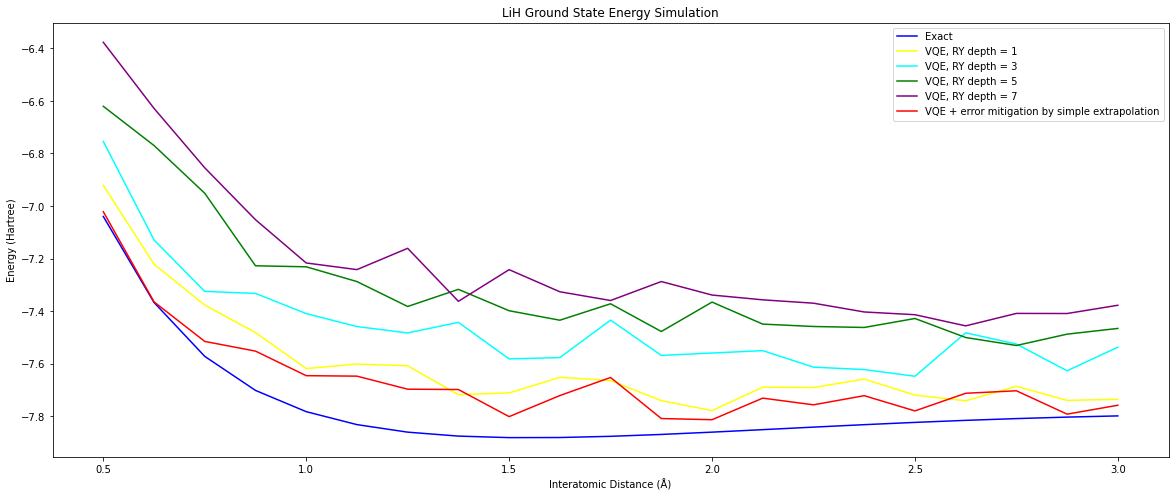

In [ ]:
plt.plot(dist_list, ref_all[0,:], color='blue', linestyle='-', label='Exact')

plt.plot(dist_list, vqe_all[0,:], color='yellow', linestyle='-', label='VQE, RY depth = 1')
plt.plot(dist_list, vqe_all[1,:], color='cyan', linestyle='-', label='VQE, RY depth = 3')
plt.plot(dist_list, vqe_all[2,:], color='green', linestyle='-', label='VQE, RY depth = 5')
plt.plot(dist_list, vqe_all[3,:], color='purple', linestyle='-', label='VQE, RY depth = 7')

plt.plot(dist_list, mitigated, color='red', linestyle='-', label='VQE + error mitigation by simple extrapolation')

plt.title('LiH Ground State Energy Simulation')
plt.xlabel('Interatomic Distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.legend()

In [ ]:
np.linspace(0.5, 3.0, 21)

array([0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125, 1.25 , 1.375, 1.5  ,
       1.625, 1.75 , 1.875, 2.   , 2.125, 2.25 , 2.375, 2.5  , 2.625,
       2.75 , 2.875, 3.   ])

In [ ]:
mapping_list = ['parity']
backend_list = ['qasm']

init_state_list = ['HF']
optimizer_list = ['COBYLA', 'SPSA']
param_list = ['RY']

score_noisefree = np.zeros((len(mapping_list)*len(init_state_list)*len(backend_list)*len(optimizer_list)*len(param_list), 6)).tolist()


inter_distance = 1.6
use_noise=True

count = 0
for i in range (len(backend_list)):
  for j in range (len(mapping_list)):
    for k in range (len(init_state_list)):
      for l in range (len(optimizer_list)):
        for m in range (len(param_list)):
          score_noisefree[count][0] = backend_list[i]
          score_noisefree[count][1] = mapping_list[j]
          score_noisefree[count][2] = init_state_list[k]
          score_noisefree[count][3] = optimizer_list[l]
          score_noisefree[count][4] = param_list[m]
          backend_type = backend_list[i]
          mapping_type = mapping_list[j]
          init_type = init_state_list[k]
          optimizer_type = optimizer_list[l]
          param_type = param_list[m]
          err = test_run(mapping_type, inter_distance, backend_type, init_type, use_noise, optimizer_type, param_type)
          score_noisefree[count][5] = err
          count += 1
          save_result('final_result_noisy3.txt', score_noisefree)
          print("Run " + str(count) + ": absolute error = ", err)


Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class

Run 1: absolute error =  0.10855486980475482
Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


Run 2: absolute error =  0.080856189554532


In [ ]:
0.7650321937608426
0.8486693939154499

In [ ]:
(0.28978775069959495+0.18632168429111617)/2

0.23805471749535556

In [ ]:
score_noisefree

[['qasm', 'parity', 'HF', 'COBYLA', 'RY', 0.10855486980475482],
 ['qasm', 'parity', 'HF', 'SPSA', 'RY', 0.080856189554532]]

In [ ]:
score_noisefree

[['qasm', 'parity', 'None', 'COBYLA', 'RY', 0.3385762324195435],
 ['qasm', 'parity', 'None', 'SPSA', 'RY', 0.28978775069959495],
 ['qasm', 'parity', 'HF', 'COBYLA', 'RY', 0.26098983910167617],
 ['qasm', 'parity', 'HF', 'SPSA', 'RY', 0.2536178720377411]]

In [ ]:
score_noisefree

[['qasm', 'parity', 'None', 'COBYLA', 'RY', 0.22365134210926674],
 ['qasm', 'parity', 'None', 'SPSA', 'RY', 0.18632168429111617],
 ['qasm', 'parity', 'HF', 'COBYLA', 'RY', 0.2786371668742237],
 ['qasm', 'parity', 'HF', 'SPSA', 'RY', 0.2852095435236244]]

In [ ]:
score_noisefree

[['qasm', 'parity', 'None', 'COBYLA', 'ESU2', 0.6017880033637941],
 ['qasm', 'parity', 'None', 'COBYLA', 'RY', 0.29940355507681604],
 ['qasm', 'parity', 'None', 'SPSA', 'ESU2', 0.4279723005209324],
 ['qasm', 'parity', 'None', 'SPSA', 'RY', 0.36287466634206145],
 ['qasm', 'parity', 'Zero', 'COBYLA', 'ESU2', 0.5940588850601642],
 ['qasm', 'parity', 'Zero', 'COBYLA', 'RY', 0.4197398089954736],
 ['qasm', 'parity', 'Zero', 'SPSA', 'ESU2', 0.3455366683455622],
 ['qasm', 'parity', 'Zero', 'SPSA', 'RY', 0.4068271182601426],
 ['qasm', 'parity', 'HF', 'COBYLA', 'ESU2', 0.3787801978321236],
 ['qasm', 'parity', 'HF', 'COBYLA', 'RY', 0.2875017011823],
 ['qasm', 'parity', 'HF', 'SPSA', 'ESU2', 0.3775065514270264],
 ['qasm', 'parity', 'HF', 'SPSA', 'RY', 0.3021503647689735]]

In [ ]:
['qasm', 'parity', 'HF', 'COBYLA', 'RY', 0.2875017011823]
['qasm', 'parity', 'HF', 'SPSA', 'RY', 0.3021503647689735]

['qasm', 'parity', 'None', 'COBYLA', 'RY', 0.29940355507681604]
['qasm', 'parity', 'None', 'SPSA', 'RY', 0.36287466634206145]

['qasm', 'parity', 'Zero', 'SPSA', 'ESU2', 0.3455366683455622]

In [ ]:
backend_type = 'qasm'
mapping_type = 'parity'
optimizer_type = 'SPSA'

init_type = 'none'
param_type = 'RY'

err = test_run(mapping_type, inter_distance, backend_type, init_type, use_noise, optimizer_type, param_type)

Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class

In [ ]:
err

0.2216727715951814

In [ ]:
backend_type = 'qasm'
mapping_type = 'parity'
optimizer_type = 'COBYLA'

init_type = 'none'
param_type = 'RY'

err = test_run(mapping_type, inter_distance, backend_type, init_type, use_noise, optimizer_type, param_type)

Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class

In [ ]:
err

0.14558101072193108

In [ ]:
backend_type = 'qasm'
mapping_type = 'parity'
optimizer_type = 'COBYLA'
use_noise = True

init_type = 'none'
param_type = 'RY'

err = test_run(mapping_type, inter_distance, backend_type, init_type, use_noise, optimizer_type, param_type)
err

Orbitals:  6
Particles:  2


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class

0.22540542222122995

In [ ]:
none + RY
Zero + ESU2
HF + RY

In [ ]:
score_noisefree

[['qasm', 'parity', 'none', 'SPSA', 'ESU2', 0.37743627780600464],
 ['qasm', 'parity', 'none', 'SPSA', 'RY', 0.23545822538872907],
 ['qasm', 'parity', 'none', 'SPSA', 'RYRZ', 0.3154474623719926]]

In [ ]:
score_noisefree

[['qasm', 'parity', 'Zero', 'SPSA', 'ESU2', 0.24477978624709196],
 ['qasm', 'parity', 'HF', 'SPSA', 'ESU2', 0.4043620027860433]]

In [ ]:
score_noisefree

[['qasm', 'parity', 'Zero', 'SPSA', 'RY', 0.3430786293721373],
 ['qasm', 'parity', 'Zero', 'SPSA', 'RYRZ', 0.4224011097108429],
 ['qasm', 'parity', 'Zero', 'SPSA', 'SwapRZ', 0.6435205872063248],
 ['qasm', 'parity', 'HF', 'SPSA', 'RY', 0.26403037890718406],
 ['qasm', 'parity', 'HF', 'SPSA', 'RYRZ', 0.4085264575527916],
 ['qasm', 'parity', 'HF', 'SPSA', 'SwapRZ', 0.3852307592386317]]

In [ ]:
score_noisefree

[['qasm', 'parity', 'Zero', 'SPSA', 'UCCSD', 0.8882404619980013],
 ['qasm', 'parity', 'HF', 'SPSA', 'UCCSD', 0.8109916846466911]]

In [ ]:
0.5244282569636363

In [ ]:
backend_list = ['qasm']
mapping_list = ['bravyi_kitaev', 'jordan_wigner']
init_state_list = ['HF', 'Zero']
optimizer_list = ['COBYLA', 'L_BFGS_B', 'SLSQP', 'SPSA']
param_list = ['UCCSD', 'RY', 'RYRZ', 'SwapRZ']

score_noisefree = np.zeros((len(mapping_list)*len(init_state_list)*len(backend_list)*len(optimizer_list)*len(param_list), 6)).tolist()

inter_distance = 1.6
use_noise=False

count = 0
for i in range (len(backend_list)):
  for j in range (len(mapping_list)):
    for k in range (len(init_state_list)):
      for l in range (len(optimizer_list)):
        for m in range (len(param_list)):
          score_noisefree[count][0] = backend_list[i]
          score_noisefree[count][1] = mapping_list[j]
          score_noisefree[count][2] = init_state_list[k]
          score_noisefree[count][3] = optimizer_list[l]
          score_noisefree[count][4] = param_list[m]
          backend_type = backend_list[i]
          mapping_type = mapping_list[j]
          init_type = init_state_list[k]
          optimizer_type = optimizer_list[l]
          param_type = param_list[m]
          err = test_run(mapping_type, inter_distance, backend_type, init_type, use_noise, optimizer_type, param_type)
          score_noisefree[count][5] = err
          count += 1
          save_result('result_noise-free_new.txt')
          print("Run " + str(count) + ": absolute error = ", err)

/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 1: absolute error =  0.008057473608764854


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.


Run 2: absolute error =  0.21272746710228174


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.


Run 3: absolute error =  0.345747380407434


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: DeprecationWarning: The qiskit.aqua.components.variational_forms.SwapRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use the qiskit.circuit.library.ExcitationPreserving object instead.


Run 4: absolute error =  1.0663200624319567


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 5: absolute error =  0.023723799188853256


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 6: absolute error =  0.8942656948521042


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 7: absolute error =  0.676724656324102


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 8: absolute error =  1.0763867525608561


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 9: absolute error =  0.019823090443696012


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 10: absolute error =  0.6536287893312782


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 11: absolute error =  0.8239978441843421


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 12: absolute error =  1.0731891925584465


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 13: absolute error =  0.00033940639017981944


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 14: absolute error =  0.19564149127826158


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 15: absolute error =  0.1514178146029772


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 16: absolute error =  1.080799180023768


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 17: absolute error =  1.0727475286177959


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 18: absolute error =  0.18542125714339064


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 19: absolute error =  0.49054334073087336


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 20: absolute error =  1.062946676563112


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 21: absolute error =  1.077572275685081


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 22: absolute error =  1.0488284720323742


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 23: absolute error =  0.7697345709143264


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 24: absolute error =  1.070743358329568


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 25: absolute error =  1.0746153320715708


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 26: absolute error =  0.9377540265591777


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 27: absolute error =  0.9371364197698944


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 28: absolute error =  1.0739485755048361


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 29: absolute error =  1.076530390421702


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 30: absolute error =  0.22685241393574396


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 31: absolute error =  0.30621164332814377


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 32: absolute error =  1.0758838515020739


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 33: absolute error =  0.006400237369535544


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 34: absolute error =  0.17400286272537724


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 35: absolute error =  0.4356932354076565


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 36: absolute error =  1.0631772356496334


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 37: absolute error =  0.01600937790473167


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 38: absolute error =  0.8936857011266549


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 39: absolute error =  0.6371450876564417


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 40: absolute error =  1.0701905743185525


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 41: absolute error =  0.012132299946344682


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 42: absolute error =  0.6722994602212315


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 43: absolute error =  0.9594719384861813


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 44: absolute error =  1.0794790767843812


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 45: absolute error =  0.11472427238517235


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 46: absolute error =  0.1189422603259136


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 47: absolute error =  0.22546875286239776


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 48: absolute error =  1.0772077047070576


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 49: absolute error =  1.073484398424216


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 50: absolute error =  0.1179316534800825


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 51: absolute error =  0.5518767840863128


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 52: absolute error =  1.061025718285195


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 53: absolute error =  1.0711899611298363


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 54: absolute error =  1.355856081722674


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 55: absolute error =  0.7953593014084395


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 56: absolute error =  1.07134923965163


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 57: absolute error =  1.074547175219231


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 58: absolute error =  0.9269793291405661


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 59: absolute error =  0.9884632419802364


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 60: absolute error =  1.0739003195981933


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 61: absolute error =  1.0741249008187221


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 62: absolute error =  0.3071623747852821


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 63: absolute error =  0.35772213042557455


/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


Run 64: absolute error =  1.080568562681406


In [ ]:
a = load_result('result_noise-free.txt')

In [ ]:
a

[['statevector', 'parity', 'HF', 'COBYLA', 'UCCSD', 3.072042220453319e-05],
 ['statevector', 'parity', 'HF', 'COBYLA', 'RY', 0.0157134358348765],
 ['statevector', 'parity', 'HF', 'COBYLA', 'RYRZ', 0.14020320484680504],
 ['statevector', 'parity', 'HF', 'COBYLA', 'SwapRZ', 0.522268457577552],
 ['statevector', 'parity', 'HF', 'L_BFGS_B', 'UCCSD', 2.733302473245658e-11],
 ['statevector', 'parity', 'HF', 'L_BFGS_B', 'RY', 0.3139236843935316],
 ['statevector', 'parity', 'HF', 'L_BFGS_B', 'RYRZ', 0.09765926792516932],
 ['statevector', 'parity', 'HF', 'L_BFGS_B', 'SwapRZ', 0.522268457577554],
 ['statevector', 'parity', 'HF', 'SLSQP', 'UCCSD', 1.6421915827180555e-08],
 ['statevector', 'parity', 'HF', 'SLSQP', 'RY', 8.218520547065289e-05],
 ['statevector', 'parity', 'HF', 'SLSQP', 'RYRZ', 0.01636009630695301],
 ['statevector', 'parity', 'HF', 'SLSQP', 'SwapRZ', 0.5222684575775531],
 ['statevector', 'parity', 'HF', 'SPSA', 'UCCSD', 0.1273435704698549],
 ['statevector', 'parity', 'HF', 'SPSA', 'RY

In [ ]:
b = load_result('result_noise-free_new.txt')
b

[['qasm', 'bravyi_kitaev', 'HF', 'COBYLA', 'UCCSD', 0.008057473608764854],
 ['qasm', 'bravyi_kitaev', 'HF', 'COBYLA', 'RY', 0.21272746710228174],
 ['qasm', 'bravyi_kitaev', 'HF', 'COBYLA', 'RYRZ', 0.345747380407434],
 ['qasm', 'bravyi_kitaev', 'HF', 'COBYLA', 'SwapRZ', 1.0663200624319567],
 ['qasm', 'bravyi_kitaev', 'HF', 'L_BFGS_B', 'UCCSD', 0.023723799188853256],
 ['qasm', 'bravyi_kitaev', 'HF', 'L_BFGS_B', 'RY', 0.8942656948521042],
 ['qasm', 'bravyi_kitaev', 'HF', 'L_BFGS_B', 'RYRZ', 0.676724656324102],
 ['qasm', 'bravyi_kitaev', 'HF', 'L_BFGS_B', 'SwapRZ', 1.0763867525608561],
 ['qasm', 'bravyi_kitaev', 'HF', 'SLSQP', 'UCCSD', 0.019823090443696012],
 ['qasm', 'bravyi_kitaev', 'HF', 'SLSQP', 'RY', 0.6536287893312782],
 ['qasm', 'bravyi_kitaev', 'HF', 'SLSQP', 'RYRZ', 0.8239978441843421],
 ['qasm', 'bravyi_kitaev', 'HF', 'SLSQP', 'SwapRZ', 1.0731891925584465],
 ['qasm', 'bravyi_kitaev', 'HF', 'SPSA', 'UCCSD', 0.00033940639017981944],
 ['qasm', 'bravyi_kitaev', 'HF', 'SPSA', 'RY', 0.

In [ ]:
for i in range (len(a)):
  if a[i][0] == b[0][0] and a[i][1] == b[0][1] and a[i][2] == b[0][2] and a[i][3] == b[0][3] and a[i][4] == b[0][4]:
    for j in range(len(b)):
      a[i+j][0] = b[j][0]
      a[i+j][1] = b[j][1]
      a[i+j][2] = b[j][2]
      a[i+j][3] = b[j][3]
      a[i+j][4] = b[j][4]
      a[i+j][5] = b[j][5]
    break

a

[['statevector', 'parity', 'HF', 'COBYLA', 'UCCSD', 3.072042220453319e-05],
 ['statevector', 'parity', 'HF', 'COBYLA', 'RY', 0.0157134358348765],
 ['statevector', 'parity', 'HF', 'COBYLA', 'RYRZ', 0.14020320484680504],
 ['statevector', 'parity', 'HF', 'COBYLA', 'SwapRZ', 0.522268457577552],
 ['statevector', 'parity', 'HF', 'L_BFGS_B', 'UCCSD', 2.733302473245658e-11],
 ['statevector', 'parity', 'HF', 'L_BFGS_B', 'RY', 0.3139236843935316],
 ['statevector', 'parity', 'HF', 'L_BFGS_B', 'RYRZ', 0.09765926792516932],
 ['statevector', 'parity', 'HF', 'L_BFGS_B', 'SwapRZ', 0.522268457577554],
 ['statevector', 'parity', 'HF', 'SLSQP', 'UCCSD', 1.6421915827180555e-08],
 ['statevector', 'parity', 'HF', 'SLSQP', 'RY', 8.218520547065289e-05],
 ['statevector', 'parity', 'HF', 'SLSQP', 'RYRZ', 0.01636009630695301],
 ['statevector', 'parity', 'HF', 'SLSQP', 'SwapRZ', 0.5222684575775531],
 ['statevector', 'parity', 'HF', 'SPSA', 'UCCSD', 0.1273435704698549],
 ['statevector', 'parity', 'HF', 'SPSA', 'RY

In [ ]:
save_result('final_result_noise-free.txt', a)

In [ ]:
final_result = pd.DataFrame(a).rename(columns={0: "backend", 1: "qubit mapping", 2: "initial state", 3: "optimizer", 4: "variational form", 5: "absolute error"})
dir = '/content/drive/My Drive/Projects/Qiskit Global Summer School/'
final_result.to_csv(dir + 'final_result_noise-free.csv')

In [ ]:
counter = 0
for i in range (len(score_noisefree)):
  if score_noisefree[i][0] == 'statevector' or score_noisefree[i][0] == 'qasm':
    counter += 1

counter

137

In [ ]:
ref -1.0770597457346915
-1.07702902531249

-1.06453928070638



In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright